# Figure 5a

In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [24]:
import sys
sys.path.append('../../')
from consensus_variables import *

In [25]:
# # Init
# # ====


# # Cancer
# cancer_cohort_df = pd.read_table(f"{path_intogen}/cohorts.tsv")

# Get data
## Cancer data

In [26]:
def get_broad_consequence(list_of_annotations):
    """
    Group variants into broader consequence types.
    """
        
    CONSEQUENCES_LIST = [
        'transcript_ablation',
        'splice_acceptor_variant',
        'splice_donor_variant',
        'stop_gained',
        'frameshift_variant',
        'stop_lost',
        'start_lost',
        'transcript_amplification',
        'inframe_insertion',
        'inframe_deletion',
        'missense_variant',
        'protein_altering_variant',
        'splice_region_variant',
        'splice_donor_5th_base_variant',
        'splice_donor_region_variant',
        'splice_polypyrimidine_tract_variant',
        'incomplete_terminal_codon_variant',
        'start_retained_variant',
        'stop_retained_variant',
        'synonymous_variant',
        'coding_sequence_variant',
        'mature_miRNA_variant',
        '5_prime_UTR_variant',
        '3_prime_UTR_variant',
        'non_coding_transcript_exon_variant',
        'intron_variant',
        'NMD_transcript_variant',
        'non_coding_transcript_variant',
        'upstream_gene_variant',
        'downstream_gene_variant',
        'TFBS_ablation',
        'TFBS_amplification',
        'TF_binding_site_variant',
        'regulatory_region_ablation',
        'regulatory_region_amplification',
        'feature_elongation',
        'regulatory_region_variant',
        'feature_truncation',
        'intergenic_variant'
    ]
    
    GROUPING_DICT = {
        'transcript_ablation': 'nonsense',
        'splice_acceptor_variant': 'nonsense',
        'splice_donor_variant': 'nonsense',
        'stop_gained': 'nonsense',
        'frameshift_variant': 'nonsense',
        'stop_lost': 'nonsense',
        'start_lost': 'nonsense',

        'missense_variant': 'missense',

        'inframe_insertion': 'indel',
        'inframe_deletion': 'indel',

        'splice_donor_variant': 'splicing',
        'splice_acceptor_variant': 'splicing',
        'splice_region_variant': 'splicing',
        'splice_donor_5th_base_variant': 'splicing',
        'splice_donor_region_variant': 'splicing',
        'splice_polypyrimidine_tract_variant': 'splicing',

        'synonymous_variant': 'synonymous',
        'incomplete_terminal_codon_variant': 'synonymous',
        'start_retained_variant': 'synonymous',
        'stop_retained_variant': 'synonymous',

        'protein_altering_variant' : 'protein_altering_variant',
        'transcript_amplification' : 'transcript_amplification', 
        'coding_sequence_variant': 'coding_sequence_variant', 

        'mature_miRNA_variant': 'non_coding_exon_region',
        '5_prime_UTR_variant': 'non_coding_exon_region',
        '3_prime_UTR_variant': 'non_coding_exon_region',
        'non_coding_transcript_exon_variant': 'non_coding_exon_region',
        'NMD_transcript_variant': 'non_coding_exon_region',

        'intron_variant': 'intron_variant',

        'non_coding_transcript_variant' : 'non_coding_transcript_variant',

        'upstream_gene_variant': 'non_genic_variant',
        'downstream_gene_variant': 'non_genic_variant',
        'TFBS_ablation': 'non_genic_variant',
        'TFBS_amplification': 'non_genic_variant',
        'TF_binding_site_variant': 'non_genic_variant',
        'regulatory_region_ablation': 'non_genic_variant',
        'regulatory_region_amplification': 'non_genic_variant',
        'feature_elongation': 'non_genic_variant',
        'regulatory_region_variant': 'non_genic_variant',
        'feature_truncation': 'non_genic_variant',
        'intergenic_variant': 'non_genic_variant',
        '-'  : '-'
    }
    
    consequence_rank_dict = { consequence : rank for rank, consequence in enumerate(CONSEQUENCES_LIST) }
    rank_consequence_dict = { rank : consequence for rank, consequence in enumerate(CONSEQUENCES_LIST) }
    
    list_of_single_annotations = []
    list_of_broad_annotations = []
    for x in list_of_annotations:
        all_consequences = x.split(",")
        all_consequences_ranks = map(lambda x: consequence_rank_dict[x], all_consequences)
        single_consequence = rank_consequence_dict[min(all_consequences_ranks)]
        list_of_single_annotations.append(single_consequence)
        if single_consequence in GROUPING_DICT:
            list_of_broad_annotations.append(GROUPING_DICT[single_consequence])
        else:
            list_of_broad_annotations.append(single_consequence)

    return list_of_broad_annotations

### Functions to load tumors data

In [27]:
def get_cancer_maf_cohort(path_vep_out, lst_genes=None, only_protein_pos=True):
    
    columns_to_load = ["SYMBOL", "Location", "Protein_position", "Feature", "Consequence"]
    vep_cohort = pd.read_table(path_vep_out, usecols=columns_to_load, low_memory=False)
    if lst_genes is not None:
        vep_cohort = vep_cohort[vep_cohort["SYMBOL"].isin(lst_genes)]
    vep_cohort = vep_cohort[vep_cohort["SYMBOL"] != "-"].reset_index(drop=True)
    
    
    # here we are removing the mutations that are in splice sites
    if only_protein_pos:
        vep_cohort = vep_cohort[vep_cohort["Protein_position"] != "-"].reset_index(drop=True)
        
    cols = ["SYMBOL", "Feature", "Location", "Protein_position", "Consequence"]
    vep_cohort = vep_cohort[cols].rename(columns={"SYMBOL" : "Gene", 
                                                    "Feature" : "Ens_transcript_ID",
                                                    "Protein_position" : "Pos"})
    
    return vep_cohort


def get_cancer_maf_all(cohort_df, path_all_vep_out, lst_genes=None, only_protein_pos=True):
    
    lst_vep_out = []
    for cohort, ttype in cohort_df[["COHORT", "CANCER_TYPE"]].values:
        print(cohort)
        path_vep = f"{path_all_vep_out}/{cohort}.tsv.gz"
        if os.path.exists(path_vep):

            vep_cohort = get_cancer_maf_cohort(path_vep, lst_genes, only_protein_pos)
            vep_cohort["Cohort"] = cohort
            vep_cohort["Cancer_type"] = ttype
            lst_vep_out.append(vep_cohort)
        else:
            print(f"Path {path_vep} doesn't exist: Skipping..")
    
    df = pd.concat(lst_vep_out).reset_index(drop=True)
    df.Pos = df.Pos.apply(lambda x: 
                            int(x) if len(x.split("-")) == 1 else 
                            np.nan if (x.split("-")[0] == "?" or x.split("-")[0] == "") 
                            else int(x.split("-")[0]))
    if only_protein_pos:
        df = df.dropna(subset="Pos").reset_index(drop=True)
        df.Pos= df.Pos.astype(int)
    
    # Ensure that all indels (including frameshift) are mapped to indels and not nonsense
    df["INDEL_INFRAME"] = False
    df.loc[(df["Consequence"] == 'inframe_insertion') | (df["Consequence"] == 'inframe_deletion'), "INDEL_INFRAME"] = True
    
    # FIXME
    # this redefinition here looks dangerous to me
    df["Consequence"] = df["Consequence"].replace("frameshift_variant", "inframe_insertion") 
    df["Consequence"] = get_broad_consequence(df["Consequence"])
    
    # Parse DNA location
    df["Chr"] = df.Location.apply(lambda x: f'chr{x.split(":")[0]}')
    df["Location"] = df.Location.apply(lambda x: x.split(":")[1])
    df["DNA_pos"] = df.Location.apply(lambda x: int(x.split("-")[0]))
    
    return df.drop(columns=["Location"])

In [28]:
selected_cancer_type = "BLCA"

### Covered DNA and DNA to protein mapping

In [29]:
# add depth info
dna_prot_df = pd.read_table(f"{deepcsa_run_dir}/dna2proteinmapping/exons_splice_sites.mapping.tsv",
                           sep="\t",
                           header = 0)
#dna_prot_df = dna_prot_df.merge(depth_df, how="left", on=["CHR", "DNA_POS"])
#dna_prot_df.loc[dna_prot_df["COVERED"] == 0, "DEPTH"] = 0
dna_prot_df = dna_prot_df.rename(columns={"CHR" : "Chr",
                                          "DNA_POS" : "DNA_pos",
                                          "GENE" : "Gene",
                                          "PROT_POS" : "Protein_pos"})

dna_prot_df

,Chr,DNA_pos,Gene,CONTEXT,Protein_pos,REVERSE_STRAND,EXON,COVERED
0,chr1,26696404,ARID1A,NaN,1.0,1.0,0.0,0
1,chr1,26696405,ARID1A,NaN,1.0,1.0,0.0,0
2,chr1,26696406,ARID1A,NaN,1.0,1.0,0.0,0
3,chr1,26696407,ARID1A,NaN,2.0,1.0,0.0,0
4,chr1,26696408,ARID1A,NaN,2.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...
140207,chr19,6751207,TRIP10,NaN,601.0,1.0,14.0,0
140208,chr19,6751208,TRIP10,NaN,601.0,1.0,14.0,0
140209,chr19,6751209,TRIP10,NaN,602.0,1.0,14.0,0
140210,chr19,6751210,TRIP10,NaN,602.0,1.0,14.0,0


# Plot

In [30]:
plot_pars = {"fsize"                     : (12,9),
             "hspace"                    : 0.1,                    # General space between all tracks
             "track_title_x_coord"       : 0.83,                   # x-coordinate (respect to protein len) for track txt title
             "score_txt_x_coord"         : 1.13,                   # as track title but for track score txt
             "track_title_fontsize"      : 6,
             "ylabel_fontsize"           : 6,
             "xlabel_fontsize"           : 6,
             "ylabel_pad"                : 38,
             "ticksize"                  : 10.25,
             "legend_fontsize"           : 5,
             "legend_frameon"            : False,
             "y_labels_coord"            : [-0.05, 0.5],
             "cnsq_bbox_to_anchor"       : [1.1123, 0.9],
             "o3d_bbox_to_anchor"        : [1.27, 1.35],
             "depth_bbox_to_anchor"      : [1.086, -2.2, 1.4, 5.05],
             "depth_0_bbox_to_anchor"    : [1, -2.2, 0.35, 4.31],
             "legend_depth_fontsize"     : 10.5,
             "txt_fontsize"              : 5,
             "sse_bbox_to_anchor"        : [1.2645, 1],
             "domain_y_bbox_to_anchor"   : -3,
             "domain_x_bbox_to_anchor"   : {"ARID1A" : 1.25,
                                            "KDM6A"  : 1.245,
                                            "KMT2D"  : 1.255,
                                            "EP300"  : 1.267,
                                            "CREBBP" : 1.267,
                                            "NOTCH2" : 1.241,
                                            "KMT2C"  : 1.255
                                            },
             "sse_lw"                    : {"KMT2D"  : 1,
                                             "EP300"  : 1,
                                             "ARID1A" : 1,
                                             "CREBBP" : 1,
                                             "NOTCH2" : 1,
                                             "KMT2C"  : 1,
                                             "STAG2"  : 1,
                                             "RB1"    : 1,
                                             "RBM10"  : 1,
                                             "KDM6A"  : 1,
                                             "TP53"   : 2.2,
                                             "FGFR3"  : 1,
                                             "CDKN1A" : 4,
                                             "FOXQ1"  : 2.2,
                                             "PIK3CA" : 1,
                                             "TERT"   : 1,
                                             },
             "covered_region_y_shift"    : {"KMT2D"  : (-0.5,0),
                                             "EP300"  : (0.1,0),
                                             "ARID1A" : (0.2,-0.095),
                                             "CREBBP" : (-0.65,0),
                                             "NOTCH2" : (0,0.03),
                                             "KMT2C"  : (0,0),
                                             "STAG2"  : (-0.1,0.1),
                                             "RB1"    : (0.04,0.03),
                                             "RBM10"  : (0,0),
                                             "KDM6A"  : (-0.3,0.18),
                                             "TP53"   : (0,0),
                                             "FGFR3"  : (0,0),
                                             "CDKN1A" : (-0.4,0),
                                             "FOXQ1"  : (0.15,0),
                                             "PIK3CA" : (0,0),
                                             "TERT"   : (0,0)
                                            },
                                             
             "dpi"                       : 300,
             "colors"                    : {"nonsense"    : "#FB8E6F",  
                                             "synonymous"  : "#ACECBD", 
                                             "missense"    : "#FBD180", 
                                             "o3d_score"   : "#6DBDCC",   
                                             "o3d_cluster" : "#DAF0F8", # "skyblue",  
                                             "indel"       : "#ECC4F7", 
                                             "splicing"    : "#A1C5DF", 
                                             "vlines"      : "lightgray",
                                             "plddt_pacc"  : "#f7f3ff"
                                           },
             "sse_colors"                : {'Coil'   : "#d1d1d1", 
                                             'Helix'  : "#DDDD90", 
                                             'Ladder' : "#8ADEE6"
                                           }
            }

# Proportions of mutations by consequence

In [31]:
## Individual gene

def plot_proportion_mutation(gene_df, plot_pars, figsize=(1, 2), save=False, filename="gene_proportion.png"):
    
    cnsq_gene_df = gene_df.groupby("Consequence").Count.sum()
    total_count = cnsq_gene_df.sum()
    cnsq_gene_df = cnsq_gene_df / cnsq_gene_df.sum() * 100
    df = pd.DataFrame(cnsq_gene_df).T
    #cols = ["synonymous", "splicing", "missense", "nonsense", "indel"]
    cols = ["synonymous", "splicing", "missense", "nonsense", "indel"]
    #cols = ["indel", "nonsense", "missense", "splicing", "synonymous"]
    df = df[[col for col in cols if col in df]]
    ax = df.plot(kind='bar', stacked=True, figsize=figsize, legend=False,
                    color = [plot_pars["colors"][cnsq] for cnsq in df.columns])
    # ax.legend(bbox_to_anchor=(1.677, 1.1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel("% mutations")
    ax.set_xticks([])

    ax.bar_label(ax.containers[len(ax.containers)-1], labels=[total_count], label_type="edge", fontsize=10, color='black', padding=4)
    if save:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
                

## All genes

def get_proportion_mutation(gene_df):
    
    cnsq_gene_df = gene_df.groupby("Consequence").Count.sum()
    total_count = cnsq_gene_df.sum()
    cnsq_gene_df = cnsq_gene_df / cnsq_gene_df.sum() * 100
    df = pd.DataFrame(cnsq_gene_df).T
    
    return df

    
def add_edgecolor_for_tissue(df, count_lst, ax, shift=0, bar_width=0.5, lw=1):
    
    height = 100
    df_dummy = df[["Type"]]
    df_dummy["Dummy"] = height
    df_dummy[df_dummy['Type'] == 'Normal'].rename(columns={"Dummy" : "Normal"}).plot(
        kind='bar', ax=ax, position=1+shift, width=bar_width, color=['red'], lw=lw, edgecolor="black", fill=False)
    df_dummy[df_dummy['Type'] == 'Cancer'].rename(columns={"Dummy" : "Cancer"}).plot(
        kind='bar', ax=ax, position=0-shift, width=bar_width, color=['red'], lw=lw, edgecolor="black", fill=False)
    
    # Group the patches by their x position
    bar_positions = {}
    for patch in ax.patches:
        x_position = patch.get_x()
        if x_position not in bar_positions:
            bar_positions[x_position] = []
        bar_positions[x_position].append(patch)

    # Sort the x positions to ensure "Normal" comes before "Cancer" for each gene
    sorted_positions = sorted(bar_positions.keys())

    # Iterate through the sorted positions in pairs, applying styles
    x_txt_offset = -0.1
    for i in range(0, len(sorted_positions), 2):

        normal_patches = bar_positions[sorted_positions[i]]
        x_pos = normal_patches[0].get_x() + normal_patches[0].get_width() / 2 + x_txt_offset
        ax.text(x_pos, height + 2, count_lst[i], ha='left', va='bottom', fontsize=10, rotation=45)
        for patch in normal_patches:
            patch.set_linestyle('-')
        
        j = i + 1
        if j < len(sorted_positions): 
            cancer_patches = bar_positions[sorted_positions[j]]
            x_pos = cancer_patches[0].get_x() + cancer_patches[0].get_width() / 2 + x_txt_offset
            ax.text(x_pos, height + 2, count_lst[j], ha='left', va='bottom', fontsize=10, rotation=45)
            for patch in cancer_patches:
                patch.set_linestyle('--') 
                

def plot_proportion_mut_by_tissue(df, figsize=(10.5, 3), bar_width=0.35, shift=0.07, 
                                    title='Proportion of mutations', save=False, filename='proportion.png'):
    
    
    total_count = df.Count.values
    df = df.drop(columns="Count")
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)

    genes = df.index.get_level_values('Gene').unique()
    positions = np.arange(len(genes))

    df = df.copy()
    df_normal = df[df['Type'] == 'Normal']
    df_cancer = df[df['Type'] == 'Cancer']
    normal_cnsq = df_normal.drop(columns=["Type"]).columns
    cancer_cnsq = df_cancer.drop(columns=["Type"]).columns
    df_normal.columns = [col.capitalize() for col in df_normal.columns]
    df_cancer.columns = [col.capitalize() for col in df_cancer.columns]

    # Plot the normal and cancer bars
    normal_bars = df_normal.plot(kind='bar', stacked=True, ax=ax, position=1+shift,
                                 width=bar_width, color=[plot_pars["colors"][cnsq] for cnsq in normal_cnsq], 
                                 label=[cnsq.capitalize() for cnsq in normal_cnsq])
    cancer_bars = df_cancer.plot(kind='bar', stacked=True, ax=ax, position=0-shift,
                                 width=bar_width, color=[plot_pars["colors"][cnsq] for cnsq in cancer_cnsq], 
                                 label=[cnsq.capitalize() for cnsq in cancer_cnsq])

    # Add edges for tissue type
    add_edgecolor_for_tissue(df, total_count, ax, shift, bar_width, lw=1)

    ax.set_xticks(positions)
    ax.set_xticklabels(genes, rotation=45)
    ax.set_xlim(-0.55, len(genes) - 0.5)
    ax.set_xlabel(None)
    ax.set_ylabel('% of mutation')
    ax.set_title(title)

    # Legend
    handles, labels = ax.get_legend_handles_labels()
    labels_dict = dict(zip(labels, handles)) 
    tissue_labels_dict = {key: labels_dict[key] for key in ['Normal', 'Cancer']}
    del labels_dict['Normal']
    del labels_dict['Cancer']
    legend_mut = ax.legend(labels_dict.values(), labels_dict.keys(), title='Mutation', 
                                bbox_to_anchor=(1.03, 0.68), frameon=False,
                                # fontsize=11, title_fontsize=11
                                )
    legend_tissue = ax.legend(tissue_labels_dict.values(), tissue_labels_dict.keys(), title='Tissue', 
                                bbox_to_anchor=(1.03, 1.23), frameon=False,
                            #   fontsize=11, title_fontsize=11
                                )
    ax.add_artist(legend_mut)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if save:
        fig.savefig(filename, dpi=300, bbox_inches='tight', bbox_extra_artists=(legend_tissue,legend_mut))
    plt.show()

## The data

# Table of protein affecting mutations count (Fig6C)

In [32]:
# Protein pos
labels_prot_dict = {"Ratio mutated protein positions (Mut > 2)"  : "3+",
                   "Ratio mutated protein positions (Mut == 2)" : "2",
                   "Ratio mutated protein positions (Mut == 1)" : "1", 
                   "Ratio non mutated protein positions"        : "0"}
mut_count_colors_prot_dict = {"Mutated protein positions (Mut > 2)"        : "#A63602",
                             "Mutated protein positions (Mut == 2)"       : "#E6550E",
                             "Mutated protein positions (Mut == 1)"       : "#FD8D3D", 
                             "Non mutated protein positions"              : "#D6D6D6",

                             "Ratio mutated protein positions (Mut > 2)"  : "#A63602",
                             "Ratio mutated protein positions (Mut == 2)" : "#E6550E",
                             "Ratio mutated protein positions (Mut == 1)" : "#FD8D3D", 
                             "Ratio non mutated protein positions"        : "#D6D6D6"}

In [33]:
def get_normal_mut_info(path_maf, indel_prot_pos=False):
    
    maf_df = pd.read_table(path_maf)
    maf_df_f = maf_df.loc[(maf_df["canonical_SYMBOL"].isin(gene_order))].reset_index(drop = True)
    
    
    cols = ["canonical_SYMBOL", "CHROM", "POS", "canonical_Protein_position", "canonical_Consequence_broader", "ALT_DEPTH", "TYPE", "INDEL_INFRAME"]
    rename_map = {"canonical_SYMBOL" : "Gene", 
                    "CHROM" : "Chr",
                    "POS" : "DNA_pos",
                    "canonical_Protein_position" : "Protein_pos",
                    "canonical_Consequence_broader" : "Consequence",
                    "ALT_DEPTH" : "Alt_depth"}

    # SNV
    # ---
    maf_df_snv = maf_df_f[(maf_df_f["TYPE"].isin(["SNV"]))].reset_index(drop = True)

    # Parse    
    maf_df_snv = maf_df_snv[[col for col in cols if col in maf_df_snv.columns]].rename(columns=rename_map)
    maf_df_snv["INDEL_INFRAME"] = np.nan

    # Indels
    # ------

    maf_df_indel = maf_df_f.loc[(maf_df_f["TYPE"].isin(["INSERTION", "DELETION"]))].reset_index(drop = True)
    maf_df_indel["canonical_Consequence_broader"] = "indel"
    maf_df_indel = maf_df_indel[[col for col in cols if col in maf_df_indel.columns]].rename(columns=rename_map)

    if indel_prot_pos == False:
        maf_df_indel["Protein_pos"] = np.nan

    # Parse
    # -----

    maf_final = pd.concat((maf_df_snv, maf_df_indel)).reset_index(drop=True)
    maf_final.Consequence = maf_final.Consequence.replace("splice_region_variant", "splicing")
    maf_final.Consequence = maf_final.Consequence.replace("essential_splice", "splicing")
    maf_final.Protein_pos = maf_final.Protein_pos.apply(lambda x: 
                                                        np.nan if (pd.isnull(x) or x.split("-")[0] == "?" or x.split("-")[0] == "-" or x.split("-")[0] == "") else 
                                                        int(x) if len(x.split("-")) == 1 else 
                                                        int(x.split("-")[0]) if len(x.split("-")) > 1 else np.nan).astype(float)
    maf_final.DNA_pos = maf_final.DNA_pos.astype(int)

    return maf_final



# Get table
# ---------

def get_mut_info_count(mut_df, gene, dna_prot_df, non_masked_mut_only=True):
    
    gene_mut_df = mut_df[mut_df["Gene"] == gene].reset_index(drop=True)
    gene_dna_prot_df = dna_prot_df[dna_prot_df["Gene"] == gene]
    
    
    # Positions covered (where we can call mutations from)
    # ----------------------------------------------------
    
    gene_dna_prot_df = gene_dna_prot_df[gene_dna_prot_df["COVERED"] == 1].reset_index(drop=True)
    len_res = len(gene_dna_prot_df.Protein_pos.dropna().unique()) 
    len_dna = len(gene_dna_prot_df.DNA_pos.dropna().unique())  
    if non_masked_mut_only:
        gene_mut_df = gene_mut_df[gene_mut_df.DNA_pos.isin(gene_dna_prot_df.DNA_pos)]
    
    
    # Total counts
    # ------------
    
    tot_mut = len(gene_mut_df)
    if "TYPE" in gene_mut_df.columns:
        tot_snv = len(gene_mut_df[gene_mut_df["TYPE"] == "SNV"]) 
    else:
        tot_snv = len(gene_mut_df[gene_mut_df["Consequence"] != "Indel"]) 
        
    tot_mut_missense = len(gene_mut_df[gene_mut_df["Consequence"] == "missense"])
    tot_mut_nonsense = len(gene_mut_df[gene_mut_df["Consequence"] == "nonsense"])
    tot_mut_splicing = len(gene_mut_df[gene_mut_df["Consequence"] == "splicing"])
    tot_mut_synonymous = len(gene_mut_df[gene_mut_df["Consequence"] == "synonymous"])

    tot_mut_indel = len(gene_mut_df[gene_mut_df["Consequence"] == "indel"])
    tot_mut_indel_frameshift = len(gene_mut_df[(gene_mut_df["Consequence"] == "indel") & (gene_mut_df["INDEL_INFRAME"] == False)])
    tot_mut_indel_inframe = len(gene_mut_df[(gene_mut_df["Consequence"] == "indel") & (gene_mut_df["INDEL_INFRAME"] == True)])                      
    
    
    # Mutations count
    # ---------------
    
    # Number of DNA and protein positions mutated at least once
    mut_dna = len(gene_mut_df.DNA_pos.dropna().unique())      # CDS + splicing regions
    mut_res = len(gene_mut_df.Protein_pos.dropna().unique())  # Residues + stop codon
    
    gene_dna_mut_df = gene_mut_df.value_counts("DNA_pos").reset_index().rename(columns={'count' : "Mut_count"})
    gene_res_mut_df = gene_mut_df.value_counts("Protein_pos").reset_index().rename(columns={'count' : "Mut_count"})

    print(gene_res_mut_df)
    print(gene_dna_mut_df)
    
    # Number of DNA and protein positions mutated once (counting each mutation only once per sample)
    mut_dna_once = len(gene_dna_mut_df[gene_dna_mut_df["Mut_count"] == 1])
    mut_res_once = len(gene_res_mut_df[gene_res_mut_df["Mut_count"] == 1])
    
    # Number of DNA and protein positions mutated twice (counting each mutation only once per sample)
    mut_dna_twice = len(gene_dna_mut_df[gene_dna_mut_df["Mut_count"] == 2])
    mut_res_twice = len(gene_res_mut_df[gene_res_mut_df["Mut_count"] == 2])
    
    # Number of DNA and protein positions mutated more than twice (counting each mutation only once per sample)
    mut_dna_more_twice = len(gene_dna_mut_df[gene_dna_mut_df["Mut_count"] > 2])
    mut_res_more_twice = len(gene_res_mut_df[gene_res_mut_df["Mut_count"] > 2])
    
    # Maximum number of times a DNA and protein position is mutated (counting each mutation only once per sample)
    try:
        mut_dna_max = int(gene_dna_mut_df["Mut_count"].max())
    except:
        mut_dna_max = 0
        
    try:
        mut_res_max = int(gene_res_mut_df["Mut_count"].max())
    except:
        mut_res_max = 0
    
    # Ratios
    # ------
    
    ratio_mut_dna = mut_dna / len_dna
    ratio_mut_res = mut_res / len_res
    ratio_mut_dna_once = mut_dna_once / len_dna
    ratio_mut_res_once = mut_res_once / len_res
    ratio_mut_dna_twice = mut_dna_twice / len_dna
    ratio_mut_res_twice = mut_res_twice / len_res
    ratio_mut_dna_more_twice = mut_dna_more_twice / len_dna
    ratio_mut_res_more_twice = mut_res_more_twice / len_res
    mut_dna_zero = len_dna - mut_dna
    mut_res_zero = len_res - mut_res
    ratio_mut_dna_zero = 1 - ratio_mut_dna
    ratio_mut_res_zero = 1 - ratio_mut_res
    
    return [gene, 
            tot_mut, 
            tot_snv, 
            tot_mut_missense, 
            tot_mut_nonsense, 
            tot_mut_splicing, 
            tot_mut_synonymous, 
            tot_mut_indel, 
            tot_mut_indel_frameshift, 
            tot_mut_indel_inframe,
            
            len_dna, 
            mut_dna, 
            ratio_mut_dna, 
            
            mut_dna_zero,
            ratio_mut_dna_zero,
            
            mut_dna_once, 
            ratio_mut_dna_once, 
            
            mut_dna_twice, 
            ratio_mut_dna_twice, 
            
            mut_dna_more_twice, 
            ratio_mut_dna_more_twice,
            
            len_res, 
            mut_res, 
            ratio_mut_res, 
            
            mut_res_zero,
            ratio_mut_res_zero,
            
            mut_res_once, 
            ratio_mut_res_once, 
            
            mut_res_twice, 
            ratio_mut_res_twice, 
            
            mut_res_more_twice, 
            ratio_mut_res_more_twice,
            
            mut_dna_max, 
            mut_res_max]


final_cols = ["Gene", 
              "Total mutations",
              "SNVs",
              "Missense",
              "Nonsense",
              "Splicing",
              "Synonymous",
              "Indel",
              "Indel frameshift",
              "Indel inframe",

              "DNA sites (CDS + splicing)", 
              "Mutated DNA sites", 
              "Ratio mutated DNA sites", 
              
              "Non mutated DNA sites",
              "Ratio non mutated DNA sites",

              "Mutated DNA sites (Mut == 1)", 
              "Ratio mutated DNA sites (Mut == 1)", 

              "Mutated DNA sites (Mut == 2)", 
              "Ratio mutated DNA sites (Mut == 2)", 
              
              "Mutated DNA sites (Mut > 2)", 
              "Ratio mutated DNA sites (Mut > 2)", 

              "Protein positions (Res + stop codon)",
              "Mutated protein positions", 
              "Ratio mutated protein positions",
              
              "Non mutated protein positions",
              "Ratio non mutated protein positions",

              "Mutated protein positions (Mut == 1)", 
              "Ratio mutated protein positions (Mut == 1)",

              "Mutated protein positions (Mut == 2)", 
              "Ratio mutated protein positions (Mut == 2)",
              
              "Mutated protein positions (Mut > 2)", 
              "Ratio mutated protein positions (Mut > 2)",

              "Max number mutated DNA site",
              "Max number mutated protein position"]

final_cols_sub = ["Gene", 
                  "DNA sites (CDS + splicing)", 
                  "Mutated DNA sites", 
                  "Ratio mutated DNA sites", 
                  "Protein positions (Res + stop codon)",
                  
                  "Mutated protein positions", 
                  "Ratio mutated protein positions",
                  
                  "Non mutated protein positions",
                  "Ratio non mutated protein positions",
                  
                  "Mutated protein positions (Mut == 1)", 
                  "Ratio mutated protein positions (Mut == 1)",
                  
                  "Mutated protein positions (Mut == 2)", 
                  "Ratio mutated protein positions (Mut == 2)",
                  
                  "Mutated protein positions (Mut > 2)", 
                  "Ratio mutated protein positions (Mut > 2)"]

### Obtain the table with updated coordinates

#### Table 2: do not include indels pos as affected protein position

In [34]:
# Do not include indels pos as affected protein position
normal_df = get_normal_mut_info(somatic_maf_file, indel_prot_pos=False)

normal_count_df = normal_df.groupby("Gene").apply(lambda x: get_mut_info_count(x, x.name, dna_prot_df, non_masked_mut_only=True)).tolist()
normal_count_df = pd.DataFrame(normal_count_df, 
                               columns=final_cols)

normal_count_df.to_csv("data/normal_mutation_count.corrected.filtered.no_indels_for_prot.tsv", sep="\t", index=False)

/tmp/ipykernel_3049781/3467031355.py:3: DtypeWarning: Columns (49,92,112) have mixed types. Specify dtype option on import or set low_memory=False.
  maf_df = pd.read_table(path_maf)


      Protein_pos  Mut_count
0          1721.0         32
1           633.0         27
2           581.0         22
3          2087.0         20
4           944.0         20
...           ...        ...
1156       1454.0          1
1157       1456.0          1
1158       1428.0          1
1159       1430.0          1
1160       1466.0          1

[1161 rows x 2 columns]
       DNA_pos  Mut_count
0     26779439         53
1     26780644         42
2     26773569         42
3     26779060         28
4     26762296         28
...        ...        ...
2741  26780664          1
2742  26780666          1
2743  26780669          1
2744  26780674          1
2745  26780676          1

[2746 rows x 2 columns]
     Protein_pos  Mut_count
0            1.0         44
1           10.0         33
2           65.0         26
3           48.0         24
4           49.0         21
..           ...        ...
110        125.0          1
111        122.0          1
112        150.0          1
113       

/tmp/ipykernel_3049781/12754042.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normal_count_df = normal_df.groupby("Gene").apply(lambda x: get_mut_info_count(x, x.name, dna_prot_df, non_masked_mut_only=True)).tolist()


## Plot of proportion and number of mutations by mutations count

### Check that calculations are correct

In [35]:
cols_mut_pos = [#"Non mutated protein positions",
                "Mutated protein positions (Mut == 1)", 
                "Mutated protein positions (Mut == 2)",
                "Mutated protein positions (Mut > 2)"]
cols_ratio_mut_pos = [#"Ratio non mutated protein positions",
                      "Ratio mutated protein positions (Mut == 1)",
                      "Ratio mutated protein positions (Mut == 2)",
                      "Ratio mutated protein positions (Mut > 2)"]

cols_mut_dna = [col.replace("protein positions", "DNA sites") for col in cols_mut_pos]
cols_ratio_mut_dna = [col.replace("protein positions", "DNA sites") for col in cols_ratio_mut_pos]

In [36]:
df_mut = normal_count_df[["Gene", "Protein positions (Res + stop codon)", "Mutated protein positions", "Non mutated protein positions"]].copy()
df_mut["Mut prot pos sum"] = normal_count_df.apply(lambda x: sum(x[cols_mut_pos]), axis=1)
# display(df_mut)

df_ratio = normal_count_df[["Gene", "Protein positions (Res + stop codon)", "Ratio mutated protein positions", "Ratio non mutated protein positions",]].copy()
df_ratio["Ratio mut prot pos sum"] = normal_count_df.apply(lambda x: sum(x[cols_ratio_mut_pos]), axis=1)
df_ratio

,Gene,Protein positions (Res + stop codon),Ratio mutated protein positions,Ratio non mutated protein positions,Ratio mut prot pos sum
0,ARID1A,1907,0.608810,0.391190,0.608810
1,CDKN1A,165,0.696970,0.303030,0.696970
2,CREBBP,2435,0.407803,0.592197,0.407803
3,EP300,2415,0.431470,0.568530,0.431470
4,FGFR3,313,0.383387,0.616613,0.383387
5,FOXQ1,369,0.626016,0.373984,0.626016
6,KDM6A,1454,0.455983,0.544017,0.455983
7,KMT2C,1413,0.409766,0.590234,0.409766
8,KMT2D,5520,0.583514,0.416486,0.583514
9,NOTCH2,2171,0.482727,0.517273,0.482727


In [37]:
df_mut = normal_count_df[["Gene", "DNA sites (CDS + splicing)", "Mutated DNA sites",  "Non mutated DNA sites"]].copy()
df_mut["Mut dna sum"] = normal_count_df.apply(lambda x: sum(x[cols_mut_dna]), axis=1)
# display(df_mut)

df_ratio = normal_count_df[["Gene", "DNA sites (CDS + splicing)", "Ratio mutated DNA sites", "Ratio non mutated DNA sites"]].copy()
df_ratio["Ratio mut dna sum"] = normal_count_df.apply(lambda x: sum(x[cols_ratio_mut_dna]), axis=1)
df_ratio

,Gene,DNA sites (CDS + splicing),Ratio mutated DNA sites,Ratio non mutated DNA sites,Ratio mut dna sum
0,ARID1A,6188,0.443762,0.556238,0.443762
1,CDKN1A,540,0.657407,0.342593,0.657407
2,CREBBP,8053,0.212716,0.787284,0.212716
3,EP300,7995,0.246029,0.753971,0.246029
4,FGFR3,1112,0.168165,0.831835,0.168165
5,FOXQ1,1100,0.532727,0.467273,0.532727
6,KDM6A,5086,0.413291,0.586709,0.413291
7,KMT2C,4507,0.215665,0.784335,0.215665
8,KMT2D,17886,0.398804,0.601196,0.398804
9,NOTCH2,7226,0.251038,0.748962,0.251038


### Plot

In [38]:
cols_mut_pos = ["Mutated protein positions",
                "Non mutated protein positions",
                "Mutated protein positions (Mut == 1)", 
                "Mutated protein positions (Mut == 2)",
                "Mutated protein positions (Mut > 2)"]
cols_ratio_mut_pos = ["Ratio mutated protein positions",
                      "Ratio non mutated protein positions",
                      "Ratio mutated protein positions (Mut == 1)",
                      "Ratio mutated protein positions (Mut == 2)",
                      "Ratio mutated protein positions (Mut > 2)"]
cols_mut_dna = [col.replace("protein positions", "DNA sites") for col in cols_mut_pos]
cols_ratio_mut_dna = [col.replace("protein positions", "DNA sites") for col in cols_ratio_mut_pos]

normal_mut_plot_df = normal_count_df[["Gene"] + cols_mut_dna + cols_ratio_mut_dna + cols_mut_pos + cols_ratio_mut_pos].copy()
normal_mut_plot_df["Type"] = "Normal"

mut_plot_df = normal_mut_plot_df.sort_values(["Gene", "Type"], ascending=[True, False]).set_index("Gene")
mut_plot_df

,Mutated DNA sites,Non mutated DNA sites,Mutated DNA sites (Mut == 1),Mutated DNA sites (Mut == 2),Mutated DNA sites (Mut > 2),Ratio mutated DNA sites,Ratio non mutated DNA sites,Ratio mutated DNA sites (Mut == 1),Ratio mutated DNA sites (Mut == 2),Ratio mutated DNA sites (Mut > 2),...,Non mutated protein positions,Mutated protein positions (Mut == 1),Mutated protein positions (Mut == 2),Mutated protein positions (Mut > 2),Ratio mutated protein positions,Ratio non mutated protein positions,Ratio mutated protein positions (Mut == 1),Ratio mutated protein positions (Mut == 2),Ratio mutated protein positions (Mut > 2),Type
Gene,,,,,,,,,,,,,,,,,,,,,
ARID1A,2746,3442,1492,582,672,0.443762,0.556238,0.241112,0.094053,0.108597,...,746,528,271,362,0.608810,0.391190,0.276875,0.142108,0.189827,Normal
CDKN1A,355,185,101,75,179,0.657407,0.342593,0.187037,0.138889,0.331481,...,50,44,26,45,0.696970,0.303030,0.266667,0.157576,0.272727,Normal
CREBBP,1713,6340,1237,281,195,0.212716,0.787284,0.153607,0.034894,0.024215,...,1442,636,206,151,0.407803,0.592197,0.261191,0.084600,0.062012,Normal
EP300,1967,6028,1333,332,302,0.246029,0.753971,0.166729,0.041526,0.037774,...,1373,583,232,227,0.431470,0.568530,0.241408,0.096066,0.093996,Normal
FGFR3,187,925,142,32,13,0.168165,0.831835,0.127698,0.028777,0.011691,...,193,70,35,15,0.383387,0.616613,0.223642,0.111821,0.047923,Normal
FOXQ1,586,514,264,120,202,0.532727,0.467273,0.240000,0.109091,0.183636,...,138,97,55,79,0.626016,0.373984,0.262873,0.149051,0.214092,Normal
KDM6A,2102,2984,1053,403,646,0.413291,0.586709,0.207039,0.079237,0.127015,...,791,304,120,239,0.455983,0.544017,0.209078,0.082531,0.164374,Normal
KMT2C,972,3535,754,151,67,0.215665,0.784335,0.167295,0.033503,0.014866,...,834,406,116,57,0.409766,0.590234,0.287332,0.082095,0.040340,Normal
KMT2D,7133,10753,4046,1373,1714,0.398804,0.601196,0.226210,0.076764,0.095829,...,2299,1399,721,1101,0.583514,0.416486,0.253442,0.130616,0.199457,Normal


In [39]:
normal_total_count = normal_count_df[["Gene", "Total mutations", "SNVs"]].set_index("Gene").reindex(gene_order_mutation_rate_normal)
# blca_cancer_total_count = blca_cancer_count_df[["Gene", "Total mutations", "SNVs"]].set_index("Gene").reindex(gene_order_mutation_rate_normal)
normal_total_count["Type"] = "Normal"
# blca_cancer_total_count["Type"] = "Cancer"
total_count_df = normal_total_count# pd.concat((normal_total_count, blca_cancer_total_count))
total_count_df

,Total mutations,SNVs,Type
Gene,,,
CDKN1A,1688,492,Normal
FOXQ1,1709,672,Normal
KDM6A,5694,2942,Normal
RBM10,5017,3373,Normal
KMT2D,16893,11204,Normal
STAG2,2779,1912,Normal
ARID1A,6406,3589,Normal
TP53,801,710,Normal
EP300,3735,2894,Normal


#### Plot only one tissue 

In [40]:
def add_edgecolor_for_tissue(df, cols_mut, txt_lst, n, ax, tissue, alt_txt=None, 
                             shift=0, bar_width=0.5, y_shift=0, lw=1, txt_fontsize=9):
    
    height = 100 #if n == 1 else df[cols_mut].sum(axis=1).values
    df_dummy = df[["Type"]].copy()
    df_dummy["Dummy"] = height
    
    df_dummy[df_dummy['Type'] == tissue].rename(columns={"Dummy" : tissue}).plot(
        kind='bar', ax=ax, position=0.5+shift, width=bar_width, color=['red'], lw=lw, edgecolor="white", fill=False)
    
    # Group the patches by their x position
    bar_positions = {}
    for patch in ax.patches:
        x_position = patch.get_x()
        if x_position not in bar_positions:
            bar_positions[x_position] = []
        bar_positions[x_position].append(patch)

    # Iterate through the sorted positions
    sorted_positions = sorted(bar_positions.keys())
    x_txt_offset = -0.25, -0.25
    
    for i in range(0, len(df_dummy)):
        normal_patches = bar_positions[sorted_positions[i]]
        if alt_txt is not None:
            txt = f"{alt_txt[i]}"
            x_pos = normal_patches[0].get_x() + normal_patches[0].get_width() / 2
            ax.text(x_pos, height[i]+y_shift, txt, ha='center', va='bottom', fontsize=txt_fontsize, rotation=0)
        else:
            txt = f"{txt_lst[i]}%"
            ix_txt_offset = x_txt_offset[0] if len(txt) == 2 else x_txt_offset[1]
            x_pos = normal_patches[0].get_x() + normal_patches[0].get_width() / 2 + ix_txt_offset
            ax.text(x_pos, txt_lst[i]+y_shift, txt, ha='left', va='bottom', fontsize=txt_fontsize, rotation=0)


def plot_proportion_mut_count_one_tissue(df, 
                                            count_df,
                                            plot_pars, 
                                            mut_count_colors_dict, 
                                            in_labels_dict, 
                                            tissue,
                                            ylabel_top='Number of protein\npositions', 
                                            ylabel_bottom='Proportion of mutated\nresidues (%)',
                                            figsize=(8, 4.7),
                                            bar_width=0.7, 
                                            shift=0.07, 
                                            y_shift=0,
                                            title=None, 
                                            save=False, 
                                            filename='proportion.png'):
    
    df = df[df["Type"] == tissue].copy()
    count_df = count_df[count_df["Type"] == tissue].copy()
    cols_mut = list(mut_count_colors_dict.keys())[:4]
    cols_mut_ratio = list(mut_count_colors_dict.keys())[4:]
    
    text_cols = [list(mut_count_colors_dict.keys())[0].split(" (")[0], list(mut_count_colors_dict.keys())[4].split(" (")[0]]
    mut_total, ratio_mut_total = df[text_cols[0]].values, df[text_cols[1]].values # Count and ratio of utated DNA sites or protein positions
    mut_total_count = count_df["Total mutations"].values # Count of mutations
    df = df.drop(columns = text_cols)
    
    # Create the plot
    fig, axes = plt.subplots(1, 1, 
                                figsize=figsize, 
                                # sharex=True, 
                                # gridspec_kw={'hspace': plot_pars["hspace"], 
                                #              'height_ratios': [0.5]}
                                )

    genes = df.index.get_level_values('Gene').unique()
    x_genes = np.arange(len(genes))
    
    df_normal_mut = df.loc[df['Type'] == tissue, cols_mut]
    df_normal_mut_ratio = df.loc[df['Type'] == tissue, cols_mut_ratio]

    normal_mut_cols = df_normal_mut.columns              
    normal_mut_ratio_cols = df_normal_mut_ratio.columns
    
    mut_lst = [df_normal_mut, normal_mut_cols, mut_total]
    mut_ratio_lst = [df_normal_mut_ratio, normal_mut_ratio_cols, ratio_mut_total]
        
    # for i, track in enumerate([mut_lst, mut_ratio_lst]):
    for i, track in enumerate([mut_ratio_lst]):
        df_normal, normal_cols, mtotal = track
        
        df_normal *= 100
        mtotal *= 100
        mtotal = [int(i) for i in mtotal.round()]
        alt_txt = None

        
        # Plot the normal and cancer bars
        normal_bars = df_normal.plot(kind='bar', stacked=True, ax=axes, position=0.5+shift,
                                        width=bar_width, color=[mut_count_colors_dict[col] for col in normal_cols])

        # Add edges for tissue type
        add_edgecolor_for_tissue(df, cols_mut, mtotal, 0, axes, tissue, alt_txt, 
                                    shift, bar_width, y_shift, lw=1, txt_fontsize=plot_pars["txt_fontsize"])
        
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)

    axes.set_xticks(x_genes)
    axes.set_xticklabels(genes, rotation=45)
    axes.set_xlim(-0.55, len(genes) - 0.5)
    axes.set_ylim(0,100)
    axes.set_xlabel(None)
    axes.set_ylabel(ylabel_bottom)
    # axes[0].set_ylabel(ylabel_top, fontsize=12)
    axes.legend().remove()

    # # Legend
    # # axes[0].legend().remove()
    # handles, labels = axes.get_legend_handles_labels()
    # labels_dict = dict(zip(labels, handles)) 
    # tissue_labels_dict = {key: labels_dict[key] for key in [tissue]}
    # del labels_dict[tissue]
    # labels_dict = {in_labels_dict[key]: value for key, value in labels_dict.items()}
    # legend_mut = axes.legend(labels_dict.values(), labels_dict.keys(), #title='Mutation', 
    #                        bbox_to_anchor=(1.03, 1), frameon=False, fontsize=11, title_fontsize=11)
    # # legend_tissue = axes[1].legend(tissue_labels_dict.values(), tissue_labels_dict.keys(), title='Tissue', 
    # #                           bbox_to_anchor=(1.03, 1.23), frameon=False, fontsize=11, title_fontsize=11)
    # #axes[1].add_artist(legend_mut)
    
    if title is not None:
        fig.suptitle(title,
        y=1
        )

    # plt.tight_layout()
    if save:
        fig.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()

In [41]:
# Sort genes by mutrate in normal tissue
genessss_order = mut_plot_df[mut_plot_df["Type"] == "Normal"]["Ratio mutated protein positions"].sort_values(ascending= False).index.values
genessss_order

array(['CDKN1A', 'RBM10', 'FOXQ1', 'ARID1A', 'TP53', 'KMT2D', 'NOTCH2',
       'KDM6A', 'STAG2', 'EP300', 'PIK3CA', 'KMT2C', 'CREBBP', 'FGFR3',
       'RB1', 'TERT'], dtype=object)

In [42]:
# Sort genes by mutrate in normal tissue
genessss_order = mut_plot_df[mut_plot_df["Type"] == "Normal"]["Ratio mutated protein positions"].sort_values(ascending= False).index.values
genessss_order_custom = [x for x in genessss_order if x in gene_list_fig5]
mut_plot_df = pd.concat([mut_plot_df[mut_plot_df.index == gene] for gene in genessss_order_custom])

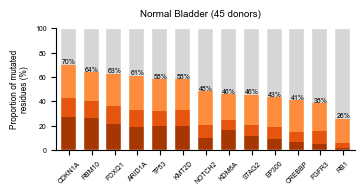

In [43]:
plot_proportion_mut_count_one_tissue(mut_plot_df,
                                    total_count_df,
                                    plot_pars, 
                                    mut_count_colors_prot_dict, 
                                    labels_prot_dict, 
                                    tissue = "Normal",
                                    title='Normal Bladder (45 donors)', 
                                    figsize=(3.85, 1.58),
                                    bar_width=0.7,
                                    save=True, 
                                    filename="plots/Fig5a_proportion_and_count_mut_prot.normal.pdf")

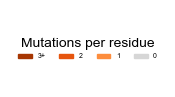

In [44]:
import matplotlib.patches as mpatches


# Create dummy patches for the legend
patch_3plus = mpatches.Patch(color='#A63602', label='3+')
patch_2 = mpatches.Patch(color='#E6550E', label='2')
patch_1 = mpatches.Patch(color='#FD8D3D', label='1')
patch_0 = mpatches.Patch(color='#D6D6D6', label='0')

# Create the plot (empty, only for the legend)
fig = plt.figure(figsize=(2, 1))
plt.axis('off')  # Hide axes

# Add the legend
plt.legend(handles=[patch_3plus, patch_2, patch_1, patch_0],
            title='Mutations per residue',
            loc='center',  ncol = 4, frameon = False)

fig.savefig('plots/Fig5a_legend.pdf', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()